# Lasso and Ridge regression

These are great techniques to fully get rid of features that aren't contributing to the prediction by putting a constraint on how high a coefficient can be (tends to zero). Ridge is alright, but cannot set a coefficient perfectly to zero. Lasso is pretty darn good.

We will use the package ```glmnet``` to fit a bunch of different types of models.

In [3]:
library(ISLR)
library(leaps)
library(glmnet)

predict.regsubsets <- function(object, newdata,id, ...){
    # object is the regsubset object
    # newdata is the data to predict on
    # id is the id of the model?
    form <- as.formula(object$call[[2]]) # Regsubset has a component called call (call used to create it aka the formula)
    mat <- model.matrix(form, newdata) # Like above we make a model matrix
    coefi <- coef(object,id=id) # Extract relevant coefficients
    mat[,names(coefi)]%*%coefi # Return the predictons we make by doing a matrix multiplication
}

# Data preprocessing from 1_Best_Subset_Selection.ipynb
Hitters <- na.omit(Hitters)

Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.1.2”
Loaded glmnet 4.1-2



```glmnet``` doesn't take a formula, rather it just takes an x and a y input

In [4]:
x = model.matrix(Salary~.-1,data=Hitters)
y=Hitters$Salary

## Ridge regression

Ridge regression doesn't make you choose between variables. Rather it lets them all be in the model, and shrinks their coefficients down to zero

Well that was easy. Lets now fit a ridge regression to our model. Super easy just need to call the command ```glmnet(x,y,alpha=0)```. Apparently the alpha=0 means Ridge, while alpha=1 would be Lasso. That makes sense considering the two techniques are so close together! **Numbers between 0 and 1 give us techniques that are somewhere between ridge and lasso????**

This technique is trying to minimize the following formula:

$RSS + \lambda\sum _{j=1} ^{P} \beta_j^2$

where P is the number of features, $\beta$ is the coefficient for that feature, and $\lambda$ is a scaling meta-variable that we can adjust to get the best results. This is a just a normal linear regression (RSS) but with a bounding term.

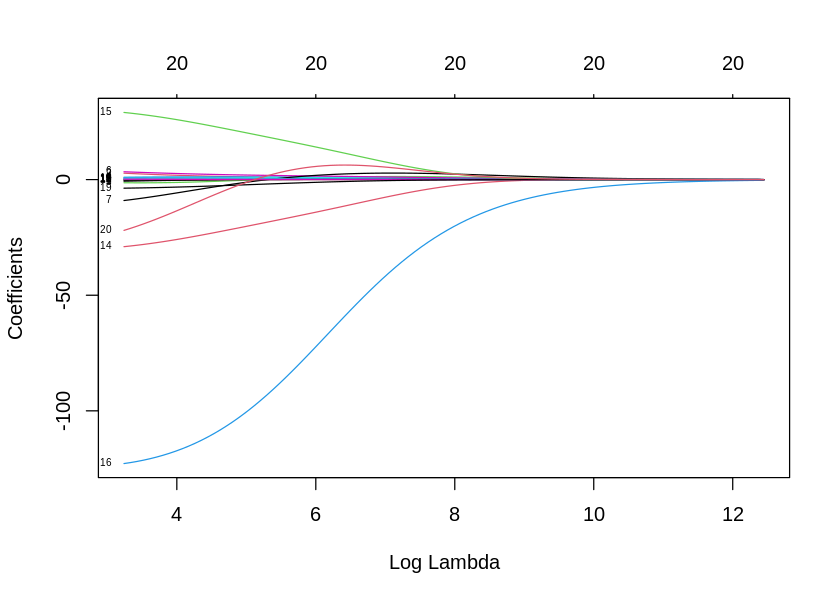

In [8]:
fit.ridge=glmnet(x,y,alpha=0)

options(repr.plot.height=5, repr.plot.width=7)
plot(fit.ridge, xvar='lambda', label=T)

### CV of Ridge to optimize $\lambda$

We can interpret the plot by looking for the minimum MSE. There is a dashed line put at the minimum, and another dashed line put at 1 SD away from the minimum. Any of these models will do, although in this case just the normal RSS seems to work just fine.

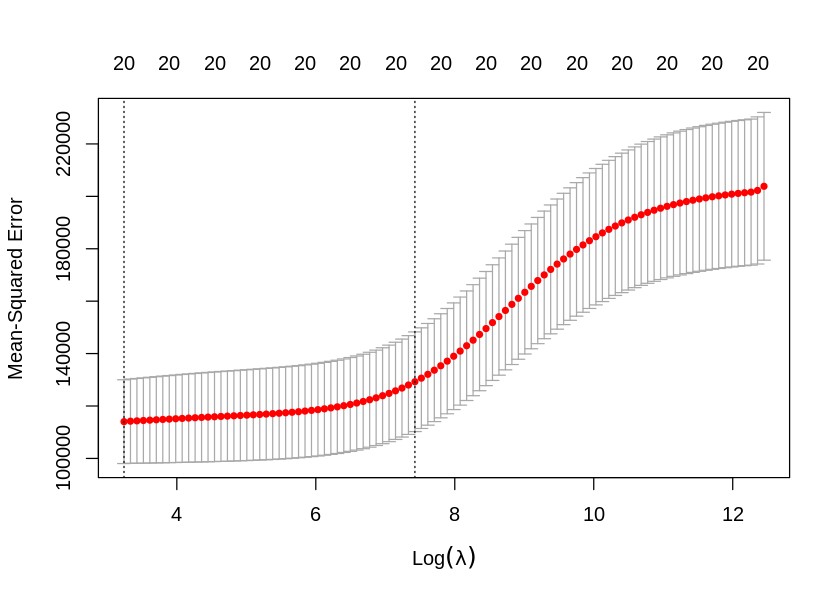

In [10]:
cv.ridge = cv.glmnet(x,y,alpha=0)
plot(cv.ridge)

## Lasso
Very similar to Ridge, but the penelty is different. Here we have the absolute value, and it allows our coefficients to perfectly equal zero!!!

$RSS + \lambda\sum _{j=1} ^{P} |\beta_j|$

When coefficients are zero, that effectively combines the effects of forward selection and Ridge regression. **We get shrinkage and feature selection!!!**

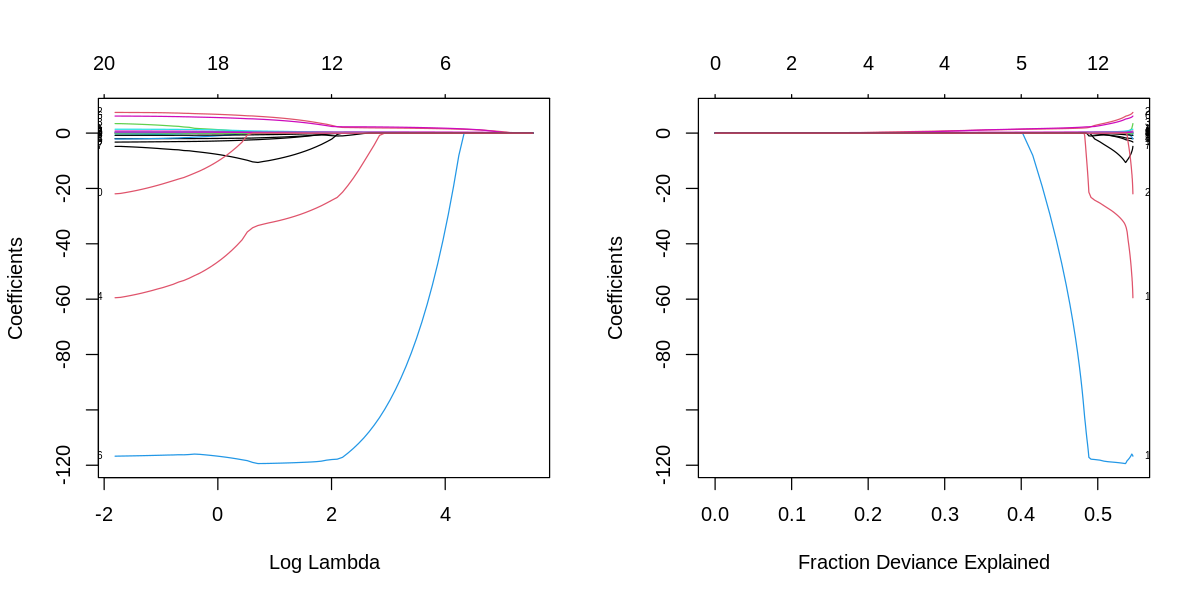

In [21]:
fit.lasso = glmnet(x,y)
par(mfrow = c(1,2)); options(repr.plot.width = 10)
plot(fit.lasso, xvar='lambda', label=T)
plot(fit.lasso, xvar='dev', label=T)
par(mfrow = c(1,1)); options(repr.plot.width = 7)

The above plot *Fraction deviance explained* is apparently interesting. Analogous to linear regression's $R^2$ interpretation as variance explained. In this case we can look at the plot and interpret it as such. When coefficients were pretty heavily shrunk, we still explained quite a bit of the variance (deviance), so they really didn't need to be as big as they were.

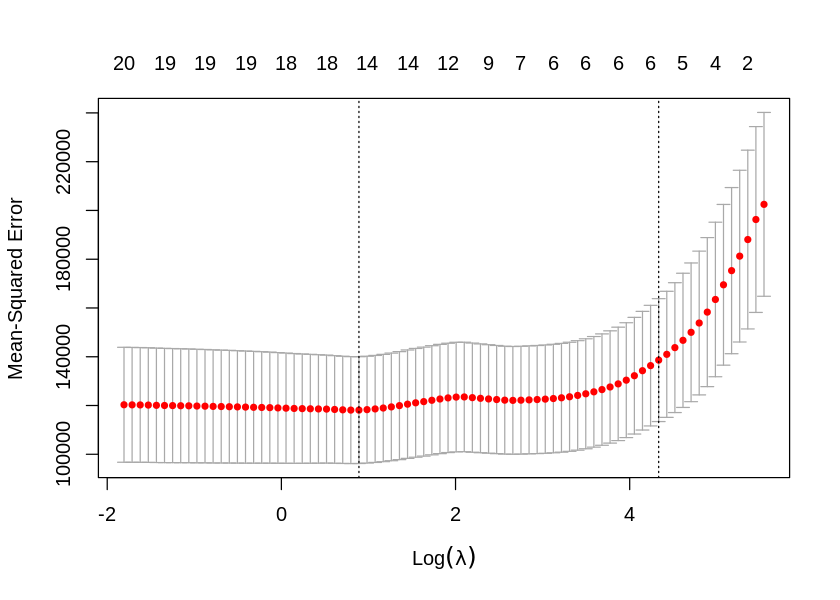

In [22]:
cv.lasso = cv.glmnet(x,y)
plot(cv.lasso)

We have a coefficient extractor function. When we use it on the ```cv.lasso``` it will give us the coefficients of the best model.

In [23]:
coef(cv.lasso)

21 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) 144.37970485
AtBat         .         
Hits          1.36380384
HmRun         .         
Runs          .         
RBI           .         
Walks         1.49731098
Years         .         
CAtBat        .         
CHits         .         
CHmRun        .         
CRuns         0.15275165
CRBI          0.32833941
CWalks        .         
LeagueA       .         
LeagueN       .         
DivisionW     .         
PutOuts       0.06625755
Assists       .         
Errors        .         
NewLeagueN    .         

### Doing train/split by hand

The output of ```lasso.tr``` will show us each model's fit, it gives DFs (degrees of freedom = # of non-zero coefs), %Dev ~ R^2, and Lambda value that made that fit.

In [56]:
set.seed(3)
train = sample(seq(263), 180, replace=F)

lasso.tr = glmnet(x[train,], y[train])
lasso.tr


Call:  glmnet(x = x[train, ], y = y[train]) 

   Df  %Dev  Lambda
1   0  0.00 263.100
2   1  5.21 239.700
3   2  9.63 218.400
4   2 15.54 199.000
5   3 20.56 181.300
6   4 24.87 165.200
7   4 28.51 150.500
8   4 31.54 137.200
9   4 34.05 125.000
10  6 36.59 113.900
11  7 39.06 103.800
12  7 41.39  94.540
13  7 43.33  86.140
14  7 44.94  78.490
15  7 46.28  71.520
16  7 47.39  65.170
17  7 48.31  59.380
18  7 49.07  54.100
19  7 49.71  49.300
20  7 50.23  44.920
21  7 50.67  40.930
22  7 51.03  37.290
23  7 51.34  33.980
24  7 51.59  30.960
25  7 51.79  28.210
26  7 51.97  25.700
27  7 52.11  23.420
28  7 52.23  21.340
29  7 52.33  19.440
30  7 52.41  17.720
31  7 52.48  16.140
32  9 52.67  14.710
33 11 52.87  13.400
34 11 53.04  12.210
35 11 53.18  11.130
36 11 53.29  10.140
37 11 53.39   9.237
38 14 53.93   8.416
39 14 54.46   7.669
40 16 55.22   6.987
41 16 55.86   6.367
42 16 56.40   5.801
43 17 56.86   5.286
44 17 57.25   4.816
45 18 57.59   4.388
46 16 57.91   3.998
47 16 58.17  

We can make predicitons

In [57]:
pred = predict(lasso.tr, x[-train,])
dim(pred)
length(y[-train])

[1] 83 78

[1] 83

We can interpret this plot as showing overfitting at the beginning, underfitting as lambda gets too high, then the dips are sweet spots.

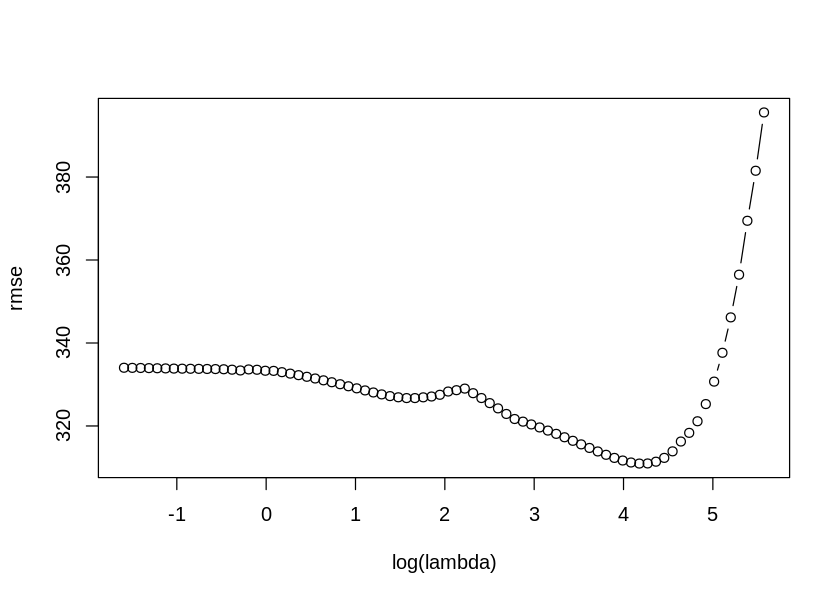

In [58]:
rmse = sqrt(apply((y[-train]-pred)^2, 2, mean))
plot(log(lasso.tr$lambda), rmse,type='b', xlab="log(lambda)")

Well lets extract the best lambda!

In [59]:
lam.best = lasso.tr$lambda[order(rmse)[1]]
print(paste0("The best lambda value is: ",lam.best))

[1] "The best lambda value is: 65.1651482895528"


In [60]:
coef(lasso.tr, s= lam.best)

21 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) 131.80938360
AtBat         .         
Hits          2.07191650
HmRun         .         
Runs          .         
RBI           .         
Walks         1.43660591
Years         .         
CAtBat        .         
CHits         .         
CHmRun        0.44683032
CRuns         0.04459242
CRBI          0.35854323
CWalks        .         
LeagueA       .         
LeagueN       .         
DivisionW   -93.29849592
PutOuts       0.11006130
Assists       .         
Errors        .         
NewLeagueN    .         

## Conclusions

I am not sure why he showed us the by-hand method. It is like CV, but worse? The ```glmnet``` function seems rather nice! We didn't cover PCR and partial least squares. 